In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from scipy.stats import entropy
import time

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [24]:
torch.manual_seed(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
train_victim, train_attacker = torch.utils.data.random_split(trainset, [25000, 15000])
train_victim_loader = torch.utils.data.DataLoader(train_victim, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
train_attacker_loader = torch.utils.data.DataLoader(train_attacker, batch_size=len(train_attacker),
                                           num_workers=2)
valloader = DataLoader(valset,batch_size = len(valset))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


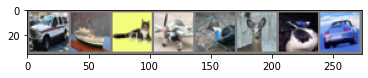

car   ship  cat   plane bird  deer  bird  car  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [46]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
def train_cifar(trainloader, valloader, model, epochs, criterion, device = None, model_name = "model_name.pt"):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    model.to(device)
    train_loss_list = []
    val_loss_list = []
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
    
    for epoch in range(epochs):
        t1 = time.time()
        print("Epoch: ", epoch+1)
        model.train()
        train_loss = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs,labels) #criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        train_loss_list.append(train_loss/len(trainloader))
        print("Train loss: ",train_loss/len(trainloader))
        model.eval()
        loss_val = 0
        for j, datas in enumerate(valloader, 0):
            ip, lbl = datas
            ip, lbl = ip.to(device), lbl.to(device)
            op = model(ip)
            val_loss = F.nll_loss(op, lbl) #criterion(op, lbl)
            loss_val += val_loss.item()
        val_loss_list.append(loss_val/len(valloader))
        print("Validation loss: ", val_loss_list[-1])
        print("Epoch time ----- ",time.time() - t1, " sec")
        if val_loss_list[-1]<=min(val_loss_list):
            print("validation loss minimum, saving model")
            torch.save(model.state_dict(),"/Users/pratik/Documents/project_ol/"+model_name)
    return train_loss_list, val_loss_list

In [8]:
def test_cifar(model, testloader, device = None):
    correct = 0
    total = 0
    model.to(device)
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100*correct/total

In [9]:
net.load_state_dict(torch.load("/Users/pratik/Documents/project_ol/al_cifar10.pt"))

<All keys matched successfully>

In [57]:
tl, vl = train_cifar(trainloader, valloader, net, epochs = 25, criterion = criterion, device = None, model_name = "al_cifar10.pt")

Using CPU
Epoch:  1


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  2.0519487785100936
Validation loss:  1.7674750089645386
Epoch time -----  20.509902000427246  sec
validation loss minimum, saving model
Epoch:  2


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.6207010170698166
Validation loss:  1.5258419513702393
Epoch time -----  20.49361300468445  sec
validation loss minimum, saving model
Epoch:  3


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.4531911142468452
Validation loss:  1.4166040420532227
Epoch time -----  20.67532205581665  sec
validation loss minimum, saving model
Epoch:  4


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.3389758197188377
Validation loss:  1.3374992609024048
Epoch time -----  20.319763898849487  sec
validation loss minimum, saving model
Epoch:  5


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.2504707343101502
Validation loss:  1.250045657157898
Epoch time -----  20.174425840377808  sec
validation loss minimum, saving model
Epoch:  6


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.1794168996393681
Validation loss:  1.2079201936721802
Epoch time -----  20.27570104598999  sec
validation loss minimum, saving model
Epoch:  7


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.1146045374661684
Validation loss:  1.1600401401519775
Epoch time -----  20.514700174331665  sec
validation loss minimum, saving model
Epoch:  8


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.0624869618937374
Validation loss:  1.125822901725769
Epoch time -----  20.818902730941772  sec
validation loss minimum, saving model
Epoch:  9


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  1.0154812232002617
Validation loss:  1.1107243299484253
Epoch time -----  20.0568208694458  sec
validation loss minimum, saving model
Epoch:  10


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.9705421679243446
Validation loss:  1.0745702981948853
Epoch time -----  20.108736038208008  sec
validation loss minimum, saving model
Epoch:  11


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.9317246355623007
Validation loss:  1.0714412927627563
Epoch time -----  20.775527954101562  sec
validation loss minimum, saving model
Epoch:  12


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.8929609926715493
Validation loss:  1.096113681793213
Epoch time -----  20.014716863632202  sec
Epoch:  13


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.859970928953588
Validation loss:  1.0735703706741333
Epoch time -----  20.126621961593628  sec
Epoch:  14


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.8239085356280208
Validation loss:  1.067948579788208
Epoch time -----  20.184950828552246  sec
validation loss minimum, saving model
Epoch:  15


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.7921957561701536
Validation loss:  1.123607873916626
Epoch time -----  20.213310956954956  sec
Epoch:  16


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.7628606207340956
Validation loss:  1.1021451950073242
Epoch time -----  20.785204887390137  sec
Epoch:  17


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.7291326539285481
Validation loss:  1.062983512878418
Epoch time -----  20.234259843826294  sec
validation loss minimum, saving model
Epoch:  18


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.7020076446861029
Validation loss:  1.1091458797454834
Epoch time -----  20.334119081497192  sec
Epoch:  19


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.6743936351500451
Validation loss:  1.1655582189559937
Epoch time -----  20.502644062042236  sec
Epoch:  20


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.6502810697142035
Validation loss:  1.1316851377487183
Epoch time -----  20.610028982162476  sec
Epoch:  21


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.6215793507058174
Validation loss:  1.166029930114746
Epoch time -----  20.25701665878296  sec
Epoch:  22


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.5979018435230479
Validation loss:  1.1826905012130737
Epoch time -----  20.200078010559082  sec
Epoch:  23


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.572641017104499
Validation loss:  1.206054925918579
Epoch time -----  20.417887926101685  sec
Epoch:  24


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.5533429920131341
Validation loss:  1.226975917816162
Epoch time -----  20.96613621711731  sec
Epoch:  25


/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

Train loss:  0.5330598859721795
Validation loss:  1.3388192653656006
Epoch time -----  20.746613025665283  sec


In [58]:
plt.figure(figsize=(10,6))
plt.plot(tl, label = "Training loss")
plt.plot(vl, label = "Validation loss")
plt.legend()

In [10]:
test_cifar(net,testloader, device = "cpu")

/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

65.35

In [43]:
def random_selection(model, unlabeled_data, num_samples: int, device = None):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    unlab_loader = DataLoader(unlabeled_data, batch_size = len(unlabeled_data))
    model.to(device)
    for i, data in enumerate(unlab_loader):
        inputs, labels = data
        inputs, labele = inputs.to(device), labels.to(device)
        probs = model(inputs)
    probs = probs.detach().cpu().numpy()
    if probs.shape[0] >= num_samples:
        selection = np.random.choice(probs.shape[0], num_samples, replace=False)
    else:
        selection = np.arange(probs.shape[0])
    return list(selection)

def margin_selection(model, unlabeled_data, num_samples:int, device = None):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    unlab_loader = DataLoader(unlabeled_data, batch_size = len(unlabeled_data))
    model.to(device)
    for i, data in enumerate(unlab_loader):
        inputs, labels = data
        inputs, labele = inputs.to(device), labels.to(device)
        probs = model(inputs)
    probs = probs.detach().cpu().numpy()
    rev = np.sort(probs, axis=1)[:, ::-1]
    values = rev[:, 0] - rev[:, 1]
    if len(probs) >= num_samples:
        selection = np.argsort(values)[:num_samples]
    else:
        selection = np.argsort(values)
    return list(selection)

def entropy_sampling(model, unlabeled_data, num_samples, device = None):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    unlab_loader = DataLoader(unlabeled_data, batch_size = len(unlabeled_data))
    model.to(device)
    for i, data in enumerate(unlab_loader):
        inputs, labels = data
        inputs, labele = inputs.to(device), labels.to(device)
        probs = model(inputs)
    probs = probs.detach().cpu().numpy()
    ent = entropy(probs, axis = 1)
    if len(probs)>=num_samples:
        selection = np.argsort(ent)[:num_samples]
    else:
        selection = np.argsort(ent)
    return list(selection)

In [51]:
def AL_cifar(model, train_data, val_data, test_data, epochs, rounds, budget, init_samples, criterion, sampling = random_selection, batch_size = 8, keep_old = True, device = None, model_name = "model_name.pt"):
    if device == None:
        print("Using CPU")
        device = torch.device("cpu")
    elif device == "cuda":
        if torch.cuda.is_available():
            print("Using CUDA")
            device = torch.device("cuda")
        else:
            print("Cuda not found. Using CPU.")
            device =torch.device("cpu")
    elif device == "mps":
        if torch.has_mps:
            print("Using MPS")
            device = torch.device("mps")
        else:
            print("MPS not found. Using CPU")
            device = torch.device("cpu")
    init_idx = random.sample(range(0,len(train_data)), init_samples)
    train_idx = init_idx
    train_step_data = Subset(train_data, train_idx)
    train_loader = DataLoader(train_step_data, batch_size= batch_size, shuffle = True)
    valid_loader = DataLoader(val_data, batch_size = len(val_data))
    test_loader = DataLoader(test_data,batch_size = len(test_data))
    test_acc = 0
    test_acc_list = [test_cifar(model, test_loader, device = device)]
    print("test acc", test_acc_list[0])
    for i in range(rounds):
        print("rounds = ",i+1,"------", "Datapoints = ", len(train_idx))
        train_loss, val_loss = train_cifar(train_loader, valid_loader, model, epochs = epochs, criterion= criterion, device = device, model_name = model_name)
        test_acc = test_cifar(model, test_loader, device = device)
        test_acc_list.append(test_acc)
        unlabeled_data_idx = list(set(range(0,len(train_data))) - set(train_idx))
        new_idx = sampling(model, Subset(train_data, unlabeled_data_idx), num_samples = budget, device = device)
        print("New data points selected")
        if keep_old:
            train_idx = list(train_idx) + list(new_idx)
        else:
            train_idx = list(new_idx)
        train_step_data = Subset(train_data, train_idx)
        train_loader = DataLoader(train_step_data, batch_size = batch_size, shuffle = True)
        model.load_state_dict(torch.load("/Users/pratik/Documents/project_ol/" + model_name))
        print("Best model loaded")
        print("test acc",test_acc)
    return test_acc_list

In [33]:
unlab_x = []
unlab_y = []
for j,k in train_attacker_loader:
    for i in range(j.shape[0]):
        unlab_x.append(j[i])
    unlab_y = torch.argmax(net(j), dim = 1)

/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/pratik/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Expected in: /Users/pratik/Library/Python/3.8/lib/python/site-pack

In [38]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx].item()
        return x, y

In [39]:
unlab_dataset = dataset(unlab_x, unlab_y)

# Random sampling

In [52]:
net2 = Net()
# net2 = Cifar10CnnModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum = 0.9)

In [53]:
tal_random = AL_cifar(net2, unlab_dataset, valset, testset, epochs = 6, rounds = 30, budget = 300, init_samples = 1500, batch_size = 8, criterion = criterion, sampling = random_selection, keep_old = True, model_name = "cifar_random.pt")

Using CPU
test acc 10.0
rounds =  1 ------ Datapoints =  1500
Epoch:  1
Train loss:  2.2966778925124633
Validation loss:  2.3032093048095703
Epoch time -----  1.04585599899292  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.287782021025394
Validation loss:  2.3005266189575195
Epoch time -----  1.0967659950256348  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.2784206042898463
Validation loss:  2.2970404624938965
Epoch time -----  1.0648531913757324  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.2643110346286854
Validation loss:  2.2875051498413086
Epoch time -----  1.1068637371063232  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  2.236287628082519
Validation loss:  2.2634682655334473
Epoch time -----  1.0382812023162842  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  2.1750423502414784
Validation loss:  2.2049357891082764
Epoch time -----  1.0529320240020752  sec
validation loss minimum, s

Train loss:  0.8919957739102548
Validation loss:  1.7007193565368652
Epoch time -----  1.432183027267456  sec
Epoch:  6
Train loss:  0.8515629931887398
Validation loss:  1.77031409740448
Epoch time -----  1.4321460723876953  sec
New data points selected
Best model loaded
test acc 46.88
rounds =  10 ------ Datapoints =  4200
Epoch:  1
Train loss:  1.0415899232455663
Validation loss:  1.6834490299224854
Epoch time -----  1.45218825340271  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.9909455745560782
Validation loss:  1.6648616790771484
Epoch time -----  1.5022578239440918  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  0.9523864231223151
Validation loss:  1.6714515686035156
Epoch time -----  1.5141007900238037  sec
Epoch:  4
Train loss:  0.8931247620355516
Validation loss:  1.706072211265564
Epoch time -----  1.4568231105804443  sec
Epoch:  5
Train loss:  0.8511794765506472
Validation loss:  1.766111135482788
Epoch time -----  1.4409980773925781  s

Validation loss:  1.9961124658584595
Epoch time -----  1.8359451293945312  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.5325259635805532
Validation loss:  1.9907342195510864
Epoch time -----  1.853774070739746  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  0.487697155047575
Validation loss:  2.0787830352783203
Epoch time -----  1.8716070652008057  sec
Epoch:  4
Train loss:  0.4353539228745815
Validation loss:  2.100924015045166
Epoch time -----  1.8945510387420654  sec
Epoch:  5
Train loss:  0.37983119875184007
Validation loss:  2.3062777519226074
Epoch time -----  1.8098011016845703  sec
Epoch:  6
Train loss:  0.3299739177275108
Validation loss:  2.4548144340515137
Epoch time -----  1.8188951015472412  sec
New data points selected
Best model loaded
test acc 48.56
rounds =  20 ------ Datapoints =  7200
Epoch:  1
Train loss:  0.5198585037949185
Validation loss:  1.9994189739227295
Epoch time -----  1.8725261688232422  sec
validation loss minimum,

Train loss:  0.15110525008756667
Validation loss:  3.18255615234375
Epoch time -----  2.2849018573760986  sec
Epoch:  6
Train loss:  0.13571175600557278
Validation loss:  3.4747867584228516
Epoch time -----  2.201265811920166  sec
New data points selected
Best model loaded
test acc 48.12
rounds =  29 ------ Datapoints =  9900
Epoch:  1
Train loss:  0.2957136373411562
Validation loss:  2.6247620582580566
Epoch time -----  2.342521905899048  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.24316317446474198
Validation loss:  2.6965131759643555
Epoch time -----  2.3118221759796143  sec
Epoch:  3
Train loss:  0.1947069720617873
Validation loss:  2.9916491508483887
Epoch time -----  2.2618489265441895  sec
Epoch:  4
Train loss:  0.1573630545708849
Validation loss:  3.158355951309204
Epoch time -----  2.240954875946045  sec
Epoch:  5
Train loss:  0.16033447043011445
Validation loss:  3.1445634365081787
Epoch time -----  2.3331871032714844  sec
Epoch:  6
Train loss:  0.14128

In [59]:
net2f = Net()
# net2f = Cifar10CnnModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2f.parameters(), lr=0.001, momentum=0.9)

In [60]:
tal_random_f = AL_cifar(net2f, unlab_dataset, valset, testset, epochs = 6, rounds = 50, budget = 300, init_samples = 1500, criterion = criterion, batch_size = 8, sampling = random_selection, keep_old = False, device = None, model_name = "random_f.pt")

Using CPU
test acc 9.59
rounds =  1 ------ Datapoints =  1500
Epoch:  1
Train loss:  2.304663840760576
Validation loss:  2.3029356002807617
Epoch time -----  1.1321229934692383  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.300507257593439
Validation loss:  2.3028388023376465
Epoch time -----  1.0950679779052734  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.2972906548926173
Validation loss:  2.303025960922241
Epoch time -----  1.0670151710510254  sec
Epoch:  4
Train loss:  2.294721006078923
Validation loss:  2.3033077716827393
Epoch time -----  1.0899899005889893  sec
Epoch:  5
Train loss:  2.292402877452526
Validation loss:  2.3035879135131836
Epoch time -----  1.0502960681915283  sec
Epoch:  6
Train loss:  2.290110096018365
Validation loss:  2.3036437034606934
Epoch time -----  1.123993158340454  sec
New data points selected
Best model loaded
test acc 10.0
rounds =  2 ------ Datapoints =  300
Epoch:  1
Train loss:  2.299370809605247
Validati

Validation loss:  2.298839807510376
Epoch time -----  0.8889977931976318  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 13.61
rounds =  10 ------ Datapoints =  300
Epoch:  1
Train loss:  2.287779927253723
Validation loss:  2.2982587814331055
Epoch time -----  0.9676110744476318  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.285520490847136
Validation loss:  2.297645330429077
Epoch time -----  0.8940250873565674  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.2826263716346338
Validation loss:  2.297008514404297
Epoch time -----  0.8953568935394287  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.280275928346734
Validation loss:  2.2964770793914795
Epoch time -----  0.8881590366363525  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  2.2781867792731836
Validation loss:  2.295806646347046
Epoch time -----  0.8866379261016846  sec
validation loss minimum, saving model

New data points selected
Best model loaded
test acc 23.6
rounds =  18 ------ Datapoints =  300
Epoch:  1
Train loss:  2.054766617323223
Validation loss:  2.083902359008789
Epoch time -----  0.8949398994445801  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.007380325543253
Validation loss:  2.0727429389953613
Epoch time -----  0.8955540657043457  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  1.9792462210906179
Validation loss:  2.0699660778045654
Epoch time -----  0.89674973487854  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  1.9689879040969045
Validation loss:  2.0724518299102783
Epoch time -----  0.9600012302398682  sec
Epoch:  5
Train loss:  1.9527292753520764
Validation loss:  2.063621759414673
Epoch time -----  0.9082369804382324  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  1.9277865102416591
Validation loss:  2.0588438510894775
Epoch time -----  0.8941080570220947  sec
validation loss minimum, saving m

Validation loss:  1.9096933603286743
Epoch time -----  0.9037628173828125  sec
New data points selected
Best model loaded
test acc 31.7
rounds =  27 ------ Datapoints =  300
Epoch:  1
Train loss:  1.846870519612965
Validation loss:  1.909515619277954
Epoch time -----  0.88755202293396  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.8026318267772072
Validation loss:  1.9285306930541992
Epoch time -----  0.9119510650634766  sec
Epoch:  3
Train loss:  1.774377898166054
Validation loss:  1.9086344242095947
Epoch time -----  0.9035959243774414  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  1.7463808687109696
Validation loss:  1.8999851942062378
Epoch time -----  0.9905881881713867  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  1.720409543890702
Validation loss:  1.9030489921569824
Epoch time -----  0.8869659900665283  sec
Epoch:  6
Train loss:  1.7035882598475407
Validation loss:  1.8969959020614624
Epoch time -----  0.91327381134033

New data points selected
Best model loaded
test acc 33.82
rounds =  36 ------ Datapoints =  300
Epoch:  1
Train loss:  1.7183712250307988
Validation loss:  1.8162851333618164
Epoch time -----  0.901850700378418  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.66450760709612
Validation loss:  1.8196300268173218
Epoch time -----  0.896622896194458  sec
Epoch:  3
Train loss:  1.6261432264980518
Validation loss:  1.8426564931869507
Epoch time -----  0.9032189846038818  sec
Epoch:  4
Train loss:  1.6195859124785976
Validation loss:  1.8937181234359741
Epoch time -----  0.9725761413574219  sec
Epoch:  5
Train loss:  1.5879967793038017
Validation loss:  1.8365697860717773
Epoch time -----  0.8931100368499756  sec
Epoch:  6
Train loss:  1.5192069474019503
Validation loss:  1.858948826789856
Epoch time -----  0.896453857421875  sec
New data points selected
Best model loaded
test acc 34.81
rounds =  37 ------ Datapoints =  300
Epoch:  1
Train loss:  1.6680615795286078
Validati

Validation loss:  1.7449724674224854
Epoch time -----  0.891211986541748  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  1.6250925848358555
Validation loss:  1.8054444789886475
Epoch time -----  0.8932738304138184  sec
Epoch:  4
Train loss:  1.5847408991110952
Validation loss:  1.7722060680389404
Epoch time -----  0.9674091339111328  sec
Epoch:  5
Train loss:  1.559221066926655
Validation loss:  1.7898939847946167
Epoch time -----  0.8905341625213623  sec
Epoch:  6
Train loss:  1.5294277197436283
Validation loss:  1.7790900468826294
Epoch time -----  0.8896560668945312  sec
New data points selected
Best model loaded
test acc 36.89
rounds =  46 ------ Datapoints =  300
Epoch:  1
Train loss:  1.6528090269942033
Validation loss:  1.7436652183532715
Epoch time -----  0.9557111263275146  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.600088379885021
Validation loss:  1.7436898946762085
Epoch time -----  0.8920309543609619  sec
Epoch:  3
Train loss:  1.5

In [55]:
plt.plot(tal_random)

In [61]:
plt.plot(tal_random_f)

# Entropy sampling

In [62]:
net3 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.8)

In [63]:
tal_entropy = AL_cifar(net3, unlab_dataset, valset, testset, epochs = 2, rounds = 45, budget = 300, init_samples = 1500, criterion = criterion, batch_size = 8, sampling = entropy_sampling, keep_old = True, model_name = "entropy.pt")

Using CPU
test acc 10.54
rounds =  1 ------ Datapoints =  1500
Epoch:  1
Train loss:  2.3064878050317157
Validation loss:  2.3025999069213867
Epoch time -----  1.0814671516418457  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.303239575091829
Validation loss:  2.3021719455718994
Epoch time -----  1.0861141681671143  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 12.34
rounds =  2 ------ Datapoints =  1800
Epoch:  1
Train loss:  2.3009531773461234
Validation loss:  2.301959276199341
Epoch time -----  1.1087639331817627  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.2980246851179333
Validation loss:  2.301940441131592
Epoch time -----  1.1176409721374512  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 10.0
rounds =  3 ------ Datapoints =  2100
Epoch:  1
Train loss:  2.2937504510915776
Validation loss:  2.3022162914276123
Epoch time -----  1.19773221015930

Validation loss:  1.790361762046814
Epoch time -----  2.040879011154175  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.7637753158942786
Validation loss:  1.7690634727478027
Epoch time -----  2.019470691680908  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 47.57
rounds =  22 ------ Datapoints =  7800
Epoch:  1
Train loss:  0.7322340423709307
Validation loss:  1.8426507711410522
Epoch time -----  2.028451681137085  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.6852221899231274
Validation loss:  1.8703314065933228
Epoch time -----  1.962095022201538  sec
New data points selected
Best model loaded
test acc 48.48
rounds =  23 ------ Datapoints =  8100
Epoch:  1
Train loss:  0.7069640252720804
Validation loss:  1.846415638923645
Epoch time -----  2.0776116847991943  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.6418157543578835
Validation loss:  1.8912675380706787
Epoch time -----  

New data points selected
Best model loaded
test acc 49.25
rounds =  43 ------ Datapoints =  14100
Epoch:  1
Train loss:  0.14983068134683097
Validation loss:  3.392624616622925
Epoch time -----  2.950472354888916  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.1112299287140407
Validation loss:  3.7391855716705322
Epoch time -----  2.8936681747436523  sec
New data points selected
Best model loaded
test acc 47.79
rounds =  44 ------ Datapoints =  14400
Epoch:  1
Train loss:  0.13764651812515188
Validation loss:  3.4967191219329834
Epoch time -----  3.082301139831543  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.10658492053191164
Validation loss:  3.7910118103027344
Epoch time -----  2.8896708488464355  sec
New data points selected
Best model loaded
test acc 48.86
rounds =  45 ------ Datapoints =  14700
Epoch:  1
Train loss:  0.12683704116598035
Validation loss:  3.6397922039031982
Epoch time -----  3.047006845474243  sec
validation loss minimum, 

In [67]:
net3f = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3f.parameters(), lr=0.001, momentum=0.8)

In [68]:
tal_entropy_f = AL_cifar(net3f, trainset, valset, testset, epochs = 6, rounds = 50, budget = 700, init_samples = 1500, criterion = criterion, batch_size = 32, sampling = entropy_sampling, keep_old = False, model_name = "entropy_f.pt")

Using CPU
test acc 9.08
rounds =  1 ------ Datapoints =  1500
Epoch:  1
Train loss:  2.3021346812552594
Validation loss:  2.30364727973938
Epoch time -----  1.0992560386657715  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.3016537909812116
Validation loss:  2.303358316421509
Epoch time -----  1.1012449264526367  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.3012967312589603
Validation loss:  2.3030619621276855
Epoch time -----  1.0872771739959717  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.300839692988294
Validation loss:  2.302783250808716
Epoch time -----  1.087676763534546  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  2.300430318142505
Validation loss:  2.3024933338165283
Epoch time -----  1.2141008377075195  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  2.300016240870699
Validation loss:  2.3021938800811768
Epoch time -----  1.091773271560669  sec
validation loss minimum, saving

New data points selected
Best model loaded
test acc 18.56
rounds =  9 ------ Datapoints =  700
Epoch:  1
Train loss:  2.2858127789063887
Validation loss:  2.2841641902923584
Epoch time -----  0.9785552024841309  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.284049077467485
Validation loss:  2.2830543518066406
Epoch time -----  0.947131872177124  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.2821791605515913
Validation loss:  2.281865358352661
Epoch time -----  0.9533240795135498  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.280265298756686
Validation loss:  2.280656337738037
Epoch time -----  0.9492940902709961  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  2.2782289439981636
Validation loss:  2.279313087463379
Epoch time -----  1.0277776718139648  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  2.276085051623258
Validation loss:  2.2778899669647217
Epoch time -----  0.9492008686065674  

Validation loss:  2.06594181060791
Epoch time -----  1.0388400554656982  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 25.17
rounds =  17 ------ Datapoints =  700
Epoch:  1
Train loss:  2.0644584569064053
Validation loss:  2.0635969638824463
Epoch time -----  0.9832189083099365  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.0509163412180813
Validation loss:  2.0565266609191895
Epoch time -----  0.960536003112793  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.0424095554785295
Validation loss:  2.0544190406799316
Epoch time -----  0.9453549385070801  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.0334835431792517
Validation loss:  2.048534870147705
Epoch time -----  0.9709620475769043  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  2.0245642987164585
Validation loss:  2.046177864074707
Epoch time -----  1.0422027111053467  sec
validation loss minimum, saving mod

Validation loss:  1.8987812995910645
Epoch time -----  0.9543819427490234  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.861884062940424
Validation loss:  1.8992749452590942
Epoch time -----  0.9438278675079346  sec
Epoch:  3
Train loss:  1.8563641038807956
Validation loss:  1.8972433805465698
Epoch time -----  0.938021183013916  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  1.856600279157812
Validation loss:  1.8943959474563599
Epoch time -----  1.0274438858032227  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  1.8426954366944053
Validation loss:  1.894639492034912
Epoch time -----  0.946483850479126  sec
Epoch:  6
Train loss:  1.8407660885290666
Validation loss:  1.8954980373382568
Epoch time -----  0.9471380710601807  sec
New data points selected
Best model loaded
test acc 31.43
rounds =  26 ------ Datapoints =  700
Epoch:  1
Train loss:  1.907780723138289
Validation loss:  1.8904447555541992
Epoch time -----  0.9452519416809

Validation loss:  1.7923063039779663
Epoch time -----  0.9477710723876953  sec
Epoch:  4
Train loss:  1.7576399824836038
Validation loss:  1.7739328145980835
Epoch time -----  1.031662940979004  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  1.7458742748607288
Validation loss:  1.784644365310669
Epoch time -----  0.9428281784057617  sec
Epoch:  6
Train loss:  1.7426017739556052
Validation loss:  1.7689154148101807
Epoch time -----  0.9464318752288818  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 35.89
rounds =  34 ------ Datapoints =  700
Epoch:  1
Train loss:  1.7372600761326877
Validation loss:  1.7672654390335083
Epoch time -----  0.9627480506896973  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.7229440970854326
Validation loss:  1.765636920928955
Epoch time -----  1.030735969543457  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  1.7141127586364746
Validation loss:  1.7640295028

Validation loss:  1.6804466247558594
Epoch time -----  0.9676210880279541  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.6518814997239546
Validation loss:  1.6724262237548828
Epoch time -----  0.9440970420837402  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  1.640610012141141
Validation loss:  1.6754416227340698
Epoch time -----  0.9535229206085205  sec
Epoch:  4
Train loss:  1.6219913905317134
Validation loss:  1.6733152866363525
Epoch time -----  0.9460108280181885  sec
Epoch:  5
Train loss:  1.611412454735149
Validation loss:  1.6722675561904907
Epoch time -----  1.0148398876190186  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  1.5961945056915283
Validation loss:  1.6710435152053833
Epoch time -----  0.9389100074768066  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 39.53
rounds =  43 ------ Datapoints =  700
Epoch:  1
Train loss:  1.653828962282701
Validation loss:  1.672132968

Validation loss:  1.626592755317688
Epoch time -----  0.9432179927825928  sec
New data points selected
Best model loaded
test acc 41.47


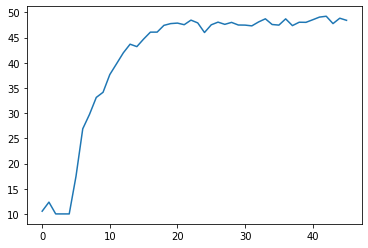

In [64]:
plt.plot(tal_entropy)

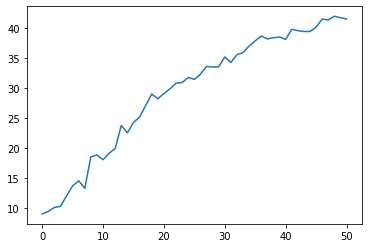

In [69]:
plt.plot(tal_entropy_f)

# Margin sampling

In [70]:
net4 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net4.parameters(), lr=0.001, momentum=0.8)

In [71]:
tal_margin = AL_cifar(net4, unlab_dataset, valset, testset, epochs = 2, rounds = 30, budget = 300, init_samples = 1500, criterion = criterion, batch_size = 8, sampling = margin_selection, keep_old = True)

Using CPU
test acc 10.09
rounds =  1 ------ Datapoints =  1500
Epoch:  1
Train loss:  2.304757848699042
Validation loss:  2.3036723136901855
Epoch time -----  1.1253712177276611  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.299825209252378
Validation loss:  2.303712844848633
Epoch time -----  1.1695947647094727  sec
New data points selected
Best model loaded
test acc 10.0
rounds =  2 ------ Datapoints =  1800
Epoch:  1
Train loss:  2.2999338383144803
Validation loss:  2.3036787509918213
Epoch time -----  1.1107189655303955  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.29626504474216
Validation loss:  2.304039478302002
Epoch time -----  1.1253361701965332  sec
New data points selected
Best model loaded
test acc 10.0
rounds =  3 ------ Datapoints =  2100
Epoch:  1
Train loss:  2.296517301421655
Validation loss:  2.303941488265991
Epoch time -----  1.1301822662353516  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.29310527047

Validation loss:  1.7827399969100952
Epoch time -----  2.0126752853393555  sec
New data points selected
Best model loaded
test acc 47.88
rounds =  22 ------ Datapoints =  7800
Epoch:  1
Train loss:  0.8382913192877403
Validation loss:  1.702796459197998
Epoch time -----  1.9691510200500488  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.7699970432657461
Validation loss:  1.750577688217163
Epoch time -----  2.0604588985443115  sec
New data points selected
Best model loaded
test acc 48.25
rounds =  23 ------ Datapoints =  8100
Epoch:  1
Train loss:  0.7876910675364857
Validation loss:  1.7124238014221191
Epoch time -----  1.9868671894073486  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  0.7266097581942602
Validation loss:  1.9178707599639893
Epoch time -----  2.0650269985198975  sec
New data points selected
Best model loaded
test acc 47.69
rounds =  24 ------ Datapoints =  8400
Epoch:  1
Train loss:  0.7450236081580321
Validation loss:  1.7858792543

In [75]:
net4f = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net4f.parameters(), lr=0.001, momentum=0.8)

In [76]:
tal_margin_f = AL_cifar(net4f, trainset, valset, testset, epochs = 6, rounds = 50, budget = 700, init_samples = 1500, criterion = criterion, batch_size = 32, sampling = margin_selection, keep_old = False)

Using CPU
test acc 10.87
rounds =  1 ------ Datapoints =  1500
Epoch:  1
Train loss:  2.3049996355746654
Validation loss:  2.306727886199951
Epoch time -----  1.1062099933624268  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.3038853635179235
Validation loss:  2.3059306144714355
Epoch time -----  1.0815818309783936  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.302937791702595
Validation loss:  2.3052189350128174
Epoch time -----  1.0804638862609863  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.302010125302254
Validation loss:  2.3044776916503906
Epoch time -----  1.0798001289367676  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  2.301035221586836
Validation loss:  2.303703546524048
Epoch time -----  1.193018913269043  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  2.3000118529542966
Validation loss:  2.302950382232666
Epoch time -----  1.079894781112671  sec
validation loss minimum, savi

New data points selected
Best model loaded
test acc 14.03
rounds =  9 ------ Datapoints =  700
Epoch:  1
Train loss:  2.2580947659232398
Validation loss:  2.255220413208008
Epoch time -----  0.9711849689483643  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.252935463731939
Validation loss:  2.25184965133667
Epoch time -----  1.0511181354522705  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.247342835773121
Validation loss:  2.248023748397827
Epoch time -----  0.9549570083618164  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.24159434708682
Validation loss:  2.244123697280884
Epoch time -----  0.9370787143707275  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  2.2352054010738027
Validation loss:  2.2403059005737305
Epoch time -----  0.9515769481658936  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  2.2290761254050513
Validation loss:  2.2358319759368896
Epoch time -----  0.9520077705383301  se

Validation loss:  2.073274612426758
Epoch time -----  0.9662120342254639  sec
validation loss minimum, saving model
New data points selected
Best model loaded
test acc 26.5
rounds =  17 ------ Datapoints =  700
Epoch:  1
Train loss:  2.0908909765156833
Validation loss:  2.0664052963256836
Epoch time -----  0.9474539756774902  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  2.0794705694372
Validation loss:  2.0638511180877686
Epoch time -----  0.9485948085784912  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  2.073765895583413
Validation loss:  2.061511993408203
Epoch time -----  1.0291650295257568  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  2.067750795321031
Validation loss:  2.0616872310638428
Epoch time -----  0.9468069076538086  sec
Epoch:  5
Train loss:  2.0622794086282905
Validation loss:  2.0535128116607666
Epoch time -----  0.9412381649017334  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  2.0554521571506

Validation loss:  1.907390832901001
Epoch time -----  0.9650771617889404  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.9046795964241028
Validation loss:  1.9094558954238892
Epoch time -----  0.9585680961608887  sec
Epoch:  3
Train loss:  1.892280556938865
Validation loss:  1.9158765077590942
Epoch time -----  0.9383449554443359  sec
Epoch:  4
Train loss:  1.8851456913081082
Validation loss:  1.900387167930603
Epoch time -----  0.9470648765563965  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  1.8784285187721252
Validation loss:  1.9021931886672974
Epoch time -----  0.9505949020385742  sec
Epoch:  6
Train loss:  1.8702680306001143
Validation loss:  1.9187203645706177
Epoch time -----  1.029209852218628  sec
New data points selected
Best model loaded
test acc 30.88
rounds =  26 ------ Datapoints =  700
Epoch:  1
Train loss:  1.8573732484470715
Validation loss:  1.9054945707321167
Epoch time -----  0.9598541259765625  sec
validation loss minimum, sa

Validation loss:  1.7841464281082153
Epoch time -----  0.9398050308227539  sec
validation loss minimum, saving model
Epoch:  6
Train loss:  1.7506303624673323
Validation loss:  1.7860636711120605
Epoch time -----  0.9453258514404297  sec
New data points selected
Best model loaded
test acc 35.74
rounds =  34 ------ Datapoints =  700
Epoch:  1
Train loss:  1.8020435571670532
Validation loss:  1.7960342168807983
Epoch time -----  0.9520461559295654  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.7778086282990195
Validation loss:  1.7883810997009277
Epoch time -----  1.019486904144287  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  1.7741740183396773
Validation loss:  1.778798222541809
Epoch time -----  0.9555971622467041  sec
validation loss minimum, saving model
Epoch:  4
Train loss:  1.775759919123216
Validation loss:  1.7754298448562622
Epoch time -----  0.9433271884918213  sec
validation loss minimum, saving model
Epoch:  5
Train loss:  1.76077768

Validation loss:  1.7156747579574585
Epoch time -----  0.9475579261779785  sec
validation loss minimum, saving model
Epoch:  3
Train loss:  1.7010453668507663
Validation loss:  1.7261250019073486
Epoch time -----  1.0461738109588623  sec
Epoch:  4
Train loss:  1.6806442683393306
Validation loss:  1.7233614921569824
Epoch time -----  0.9776906967163086  sec
Epoch:  5
Train loss:  1.6804493340578945
Validation loss:  1.7226051092147827
Epoch time -----  0.9572772979736328  sec
Epoch:  6
Train loss:  1.6635249690576033
Validation loss:  1.7284035682678223
Epoch time -----  0.952232837677002  sec
New data points selected
Best model loaded
test acc 37.88
rounds =  43 ------ Datapoints =  700
Epoch:  1
Train loss:  1.7275705283338374
Validation loss:  1.7130491733551025
Epoch time -----  0.9540982246398926  sec
validation loss minimum, saving model
Epoch:  2
Train loss:  1.7048366449095986
Validation loss:  1.7116601467132568
Epoch time -----  1.0233051776885986  sec
validation loss minimum,

In [72]:
plt.plot(tal_margin)

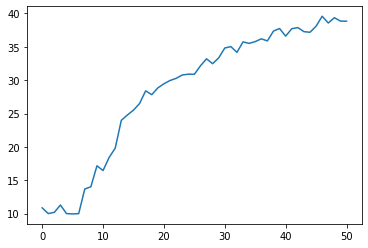

In [77]:
plt.plot(tal_margin_f)

In [78]:
plt.figure(figsize=(10,6))
plt.plot(tal_random, color = "c",label="Random sampling")
plt.plot(tal_entropy, color = "m",label="Entropy sampling")
plt.plot(tal_margin, color = "r",label="Margin sampling")
plt.legend()
plt.title("keeping all data points")

Text(0.5, 1.0, 'keeping all data points')

Text(0.5, 1.0, 'Only new data points')

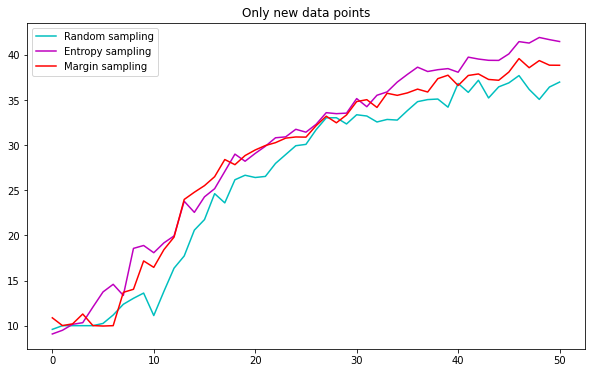

In [79]:
plt.figure(figsize=(10,6))
plt.plot(tal_random_f, color = "c",label="Random sampling")
plt.plot(tal_entropy_f, color = "m",label="Entropy sampling")
plt.plot(tal_margin_f, color = "r",label="Margin sampling")
plt.legend()
plt.title("Only new data points")